# Generic Scikit-Learn Classifier With Dask

Run any scikit-learn compatible classifier or list of classifiers

In [28]:
# nuclio: ignore
import nuclio

In [29]:
%nuclio config kind = "dask"
%nuclio config spec.image = "mlrun/ml-models"

%nuclio: setting kind to 'dask'
%nuclio: setting spec.image to 'mlrun/ml-models'


In [30]:
import warnings
warnings.filterwarnings('ignore')

import os
import joblib
import numpy as np
import pandas as pd
import sklearn
from cloudpickle import dumps, load, dump
from typing import List, Optional

from dask.distributed import Client
from dask import dataframe as dd
from dask import array as da
from dask.delayed import delayed
from dask_ml import model_selection
from dask_ml import metrics
from dask_ml.preprocessing import StandardScaler, LabelEncoder

from mlrun.execution import MLClientCtx
from mlrun.datastore import DataItem
from mlrun.artifacts import PlotArtifact
from mlrun.mlutils import (gen_sklearn_model, create_class)
import mlrun

import matplotlib.pyplot as plt
from yellowbrick.classifier import ROCAUC, ClassificationReport, ConfusionMatrix
from yellowbrick.model_selection import FeatureImportances

In [31]:
def train_model(context: MLClientCtx,
                dataset: DataItem,
                model_pkg_class: str,
                label_column: str = "label",
                train_validation_size: float = 0.75,
                sample: float = 1.0,
                models_dest: str = "models",
                test_set_key: str = "test_set",
                plots_dest: str = "plots",
                dask_key: str = "dask_key",
                dask_persist: bool = False,
                scheduler_key: str = None,
                file_ext: str = "parquet",
                random_state: int = 42) -> None:
    
    """
    Train a sklearn classifier with Dask
    
    :param context:                 Function context.
    :param dataset:                 Raw data file.
    :param model_pkg_class:         Model to train, e.g, "sklearn.ensemble.RandomForestClassifier", 
                                    or json model config.
    :param label_column:            (label) Ground-truth y labels.
    :param train_validation_size:   (0.75) Train validation set proportion out of the full dataset.
    :param sample:                  (1.0) Select sample from dataset (n-rows/% of total), randomzie rows as default.
    :param models_dest:             (models) Models subfolder on artifact path.
    :param test_set_key:            (test_set) Mlrun db key of held out data in artifact store.
    :param plots_dest:              (plots) Plot subfolder on artifact path.
    :param dask_key:                (dask key) Key of dataframe in dask client "datasets" attribute.
    :param dask_persist:            (False) Should the data be persisted (through the `client.persist`)
    :param scheduler_key:           (scheduler) Dask scheduler configuration, json also logged as an artifact.
    :param file_ext:                (parquet) format for test_set_key hold out data
    :param random_state:            (42) sklearn seed
    """
    
    if hasattr(context, "dask_client"):
        dask_client = context.dask_client
        dask_client.write_scheduler_file("scheduler.json")
        
    elif scheduler_key != None:
        dask_client = Client(scheduler_file=str(scheduler_key))
        dask_client.write_scheduler_file(scheduler_key + ".json")
        
    else:
        dask_client = Client()
        dask_client.write_scheduler_file("scheduler.json")
        
    if dask_persist:
        df = dask_client.persist(df)
        if dask_client.datasets and dask_key in dask_client.datasets:
            dask_client.unpublish_dataset(dask_key)
        dask_client.publish_dataset(df, name=dask_key)
    
    if context:
        context.dask_client = dask_client
    
    context.logger.info("Read Data")
    temp = dataset.as_df() # fix dask df ability
    
    # read data with dask
    df = dd.from_pandas(temp, chunksize=100000)
    
    # take only numrical cols
    context.logger.info("Prep Data")
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    df = df.select_dtypes(include=numerics)
    
    # dropna
    df = df.drop([c for c in df.columns if df[c].isna().any().compute()], axis = 1) # no dropna with axis param in dask
    df_header = df.columns
    
    # randomize rows or sample
    df = df.sample(frac=sample).reset_index(drop=True)
    
    # fetch x and y
    encoder = LabelEncoder()
    encoder = encoder.fit(df[label_column])
    X = df.drop(label_column, axis=1).to_dask_array(lengths=True)
    y = encoder.transform(df[label_column])

    # get classes with dask
    classes = df[label_column].drop_duplicates() # no unique values in dask
    classes = [str(i) for i in classes]

    # split train test
    context.logger.info("Split and Train")
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=train_validation_size,
                                                                        random_state=random_state)
    
    # scale data with minmax scaler
    scaler = StandardScaler()
    scaler = scaler.fit(X_train)
    X_train_transformed = scaler.transform(X_train)
    X_test_transformed = scaler.transform(X_test)
    
    # generate a model configuration and add CLASS and FIT params:
    model_config = gen_sklearn_model(model_pkg_class,
                                     context.parameters.items())

    # update FIT params with features and labels:
    model_config["FIT"].update({"X": X_train_transformed,
                                "y": y_train})
    
    # generate a scikit-learn class:
    ClassifierClass = create_class(model_config["META"]["class"])
    
    # instantiate the class with our updated CLASS params:
    model = ClassifierClass(**model_config["CLASS"])
    
    # load and fit model
    with joblib.parallel_backend("dask"):
        
        # initialize classifier from sklearn
        model = delayed(model.fit)(**model_config["FIT"]).compute()

    # log artifacts
    artifact_path = context.artifact_subpath(models_dest)
    
    # log plots
    plots_path = context.artifact_subpath(models_dest, plots_dest)

    # create reports
    context.logger.info("Evaluate")
    extra_data_dict = {}
    for report in (ROCAUC, ClassificationReport, ConfusionMatrix):
        
        report_name = str(report.__name__)
        # clear output
        plt.cla()
        plt.clf()
        plt.close()
        
        # genrate report
        viz = report(model, classes=classes, per_class=True, is_fitted=True)
        viz.fit(X_train_transformed, y_train)               # Fit the training data to the visualizer
        viz.score(X_test_transformed, y_test.compute())     # Evaluate the model on the test data
        
        # log reports
        plot = context.log_artifact(PlotArtifact(report_name, 
                                                 body=viz.fig,
                                                 title=report_name), 
                                                 db_key=False)
        extra_data_dict[str(report)] = plot
        
        # log results
        if report_name == 'ROCAUC':
            context.log_results({"micro": viz.roc_auc.get("micro"),
                                "macro": viz.roc_auc.get("macro")})
            
        elif report_name == 'ClassificationReport':
            for score_name in viz.scores_:
                for score_class in viz.scores_[score_name]:
                    
                    context.log_results({score_name + "-" + score_class : 
                                         viz.scores_[score_name].get(score_class)})
        
        viz.show()
    
    # get feature importance
    viz = FeatureImportances(model, classes=classes, per_class=True, 
                             is_fitted=True, labels=df_header.delete(df_header.get_loc(label_column)))
    viz.fit(X_train_transformed, y_train) 
    viz.score(X_test_transformed, y_test)
    viz.show()
    
    plot = context.log_artifact(PlotArtifact("FeatureImportances", body=viz.fig, 
                                             title="FeatureImportances"), db_key=False)
    extra_data_dict[str("FeatureImportances")] = plot
    
    # clear final output
    plt.cla()
    plt.clf()
    plt.close()

    # log artifacts
    context.logger.info("Log artifacts")
    artifact_path = context.artifact_subpath(models_dest)
    
    # log plots
    plots_path = context.artifact_subpath(models_dest, plots_dest)
    
    # set label
    context.set_label('class', model_pkg_class)
    
    # log models
    context.log_model("model", body=dumps(model),
                      artifact_path=artifact_path,
                      model_file="model.pkl",
                      extra_data=extra_data_dict,
                      metrics=context.results,
                      labels={"class": model_pkg_class})
    
    # log scalers
    context.log_artifact("standard_scaler", body=dumps(scaler),
                         artifact_path=artifact_path,
                         model_file="scaler.gz",
                         label="standard_scaler")
    
    # log encoder
    context.log_artifact("label_encoder", body=dumps(encoder),
                         artifact_path=artifact_path,
                         model_file="encoder.gz",
                         label="label_encoder")
    
    # set aside some test data
    df_to_save = delayed(np.column_stack)((X_test, y_test)).compute()
    context.log_dataset(test_set_key, 
                        df=pd.DataFrame(df_to_save, 
                                        columns=df_header), # improve log dataset ability
                        format=file_ext, index=False, 
                        labels={"data-type": "held-out"},
                        artifact_path=context.artifact_subpath('data'))
    
    context.logger.info("Done!")

### Save and Config

In [32]:
dsf = mlrun.code_to_function('sklearn-classifier-dask', kind='dask', code_output=".") .apply(mlrun.mount_v3io())

In [33]:
dsf.spec.image = 'mlrun/ml-models'
dsf.spec.remote = True
dsf.spec.replicas = 1
dsf.spec.service_type = 'NodePort'
dsf.export("function.yaml")

> 2020-10-26 07:17:19,519 [info] function spec saved to path: function.yaml


### Set Environment

In [34]:
artifact_path = mlrun.set_environment(api_path = 'http://mlrun-api:8080',
                                      artifact_path = os.path.abspath('./'))

### Set Parameters

In [35]:
DATA_URL = 'https://s3.wasabisys.com/iguazio/data/iris/iris_dataset.csv'


task_params = {
    "params" : {
        "sample"             : 1,
        "train_val_split"    : 0.75,
        "random_state"       : 42,
        "n_jobs"             : -1,
        "plots_dest"         : "plots-p",
        "models_dest"        : 'sklearn-clfmodel'}}


models = [
    "sklearn.ensemble.RandomForestClassifier",
    "sklearn.ensemble.AdaBoostClassifier",
    "sklearn.linear_model.LogisticRegression"
]

### Test and Run

> 2020-10-26 07:17:19,559 [info] starting run sklearn_ensemble_RandomForestClassifier uid=d7af545876064f12bc858d015a230c06  -> http://mlrun-api:8080
> 2020-10-26 07:17:24,387 [info] trying dask client at: tcp://mlrun-sklearn-classifier-dask-c66f08c6-a.default-tenant:8786
> 2020-10-26 07:17:24,403 [info] using remote dask scheduler (mlrun-sklearn-classifier-dask-c66f08c6-a) at: tcp://mlrun-sklearn-classifier-dask-c66f08c6-a.default-tenant:8786


> 2020-10-26 07:17:24,408 [info] Read Data
> 2020-10-26 07:17:24,571 [info] Prep Data
> 2020-10-26 07:17:28,264 [info] Split and Train
> 2020-10-26 07:17:29,023 [info] Evaluate


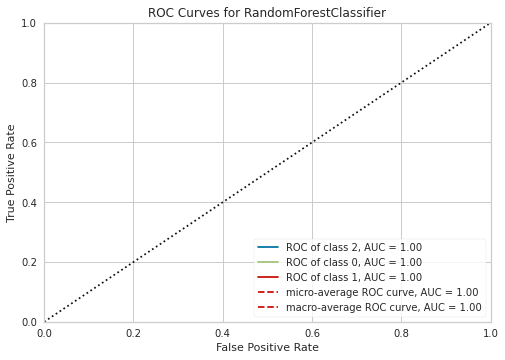

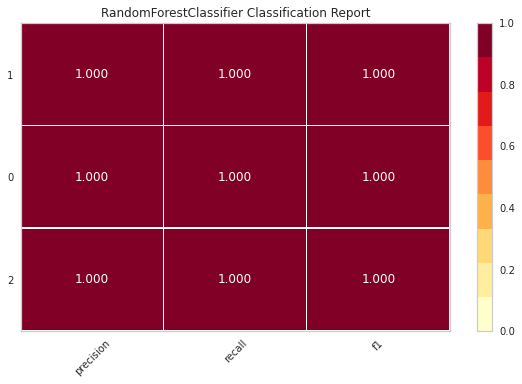

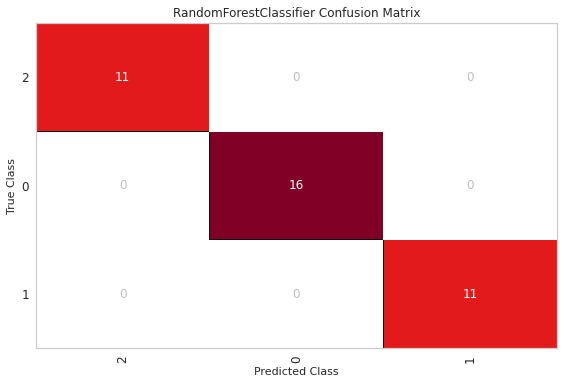

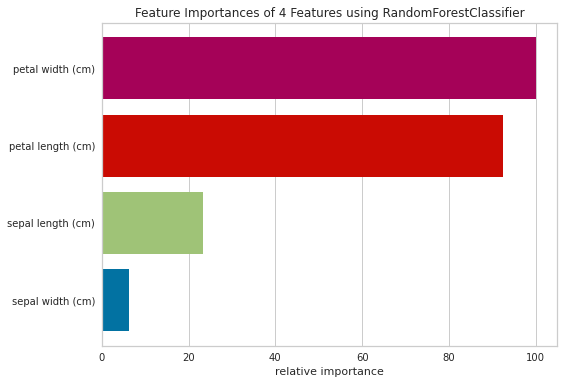

> 2020-10-26 07:17:31,148 [info] Log artifacts
> 2020-10-26 07:17:31,601 [info] Done!
> 2020-10-26 07:17:24,408 [info] Read Data
> 2020-10-26 07:17:24,571 [info] Prep Data
> 2020-10-26 07:17:28,264 [info] Split and Train
> 2020-10-26 07:17:29,023 [info] Evaluate
> 2020-10-26 07:17:31,148 [info] Log artifacts
> 2020-10-26 07:17:31,601 [info] Done!

> 2020-10-26 07:17:31,661 [warning] run ended with state 


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...5a230c06,0,Oct 26 07:17:19,completed,sklearn_ensemble_RandomForestClassifier,v3io_user=adminkind=daskowner=adminhost=jupyter-856469cd66-vd7fwclass=sklearn.ensemble.RandomForestClassifier,dataset,model_pkg_class=sklearn.ensemble.RandomForestClassifierlabel_column=labelCLASS_max_depth=5,micro=1.0macro=1.0precision-2=1.0precision-0=1.0precision-1=1.0recall-2=1.0recall-0=1.0recall-1=1.0f1-2=1.0f1-0=1.0f1-1=1.0,ROCAUCClassificationReportConfusionMatrixFeatureImportancesmodelstandard_scalerlabel_encodertest_set


to track results use .show() or .logs() or in CLI: 
!mlrun get run d7af545876064f12bc858d015a230c06 --project default , !mlrun logs d7af545876064f12bc858d015a230c06 --project default
> 2020-10-26 07:17:31,677 [info] run executed, status=completed
> 2020-10-26 07:17:31,678 [info] starting run sklearn_ensemble_AdaBoostClassifier uid=0740b76a9a2a4f6283d1551af40ab58c  -> http://mlrun-api:8080
> 2020-10-26 07:17:31,928 [info] trying dask client at: tcp://mlrun-sklearn-classifier-dask-c66f08c6-a.default-tenant:8786
> 2020-10-26 07:17:31,935 [info] using remote dask scheduler (mlrun-sklearn-classifier-dask-c66f08c6-a) at: tcp://mlrun-sklearn-classifier-dask-c66f08c6-a.default-tenant:8786


> 2020-10-26 07:17:31,941 [info] Read Data
> 2020-10-26 07:17:32,045 [info] Prep Data
> 2020-10-26 07:17:32,349 [info] Split and Train
> 2020-10-26 07:17:32,799 [info] Evaluate


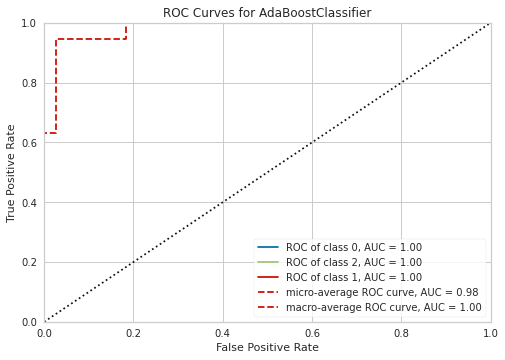

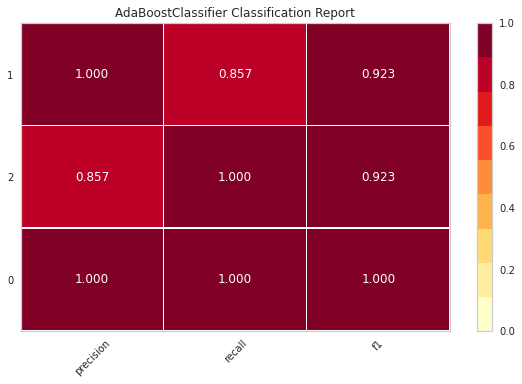

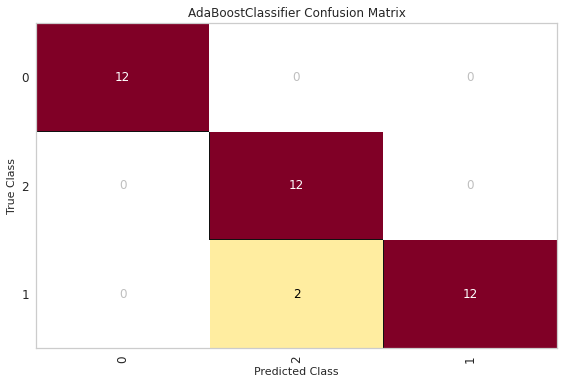

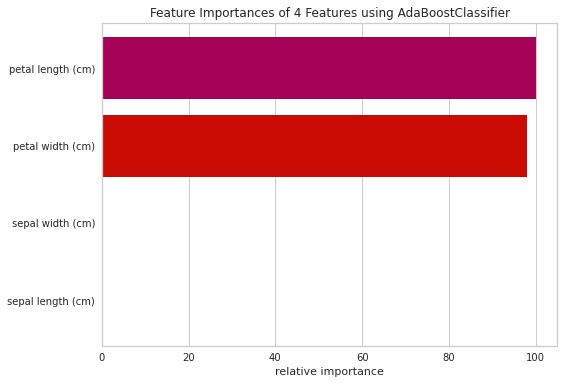

> 2020-10-26 07:17:34,912 [info] Log artifacts
> 2020-10-26 07:17:35,278 [info] Done!
> 2020-10-26 07:17:31,941 [info] Read Data
> 2020-10-26 07:17:32,045 [info] Prep Data
> 2020-10-26 07:17:32,349 [info] Split and Train
> 2020-10-26 07:17:32,799 [info] Evaluate
> 2020-10-26 07:17:34,912 [info] Log artifacts
> 2020-10-26 07:17:35,278 [info] Done!

> 2020-10-26 07:17:35,337 [warning] run ended with state 


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...f40ab58c,0,Oct 26 07:17:31,completed,sklearn_ensemble_AdaBoostClassifier,v3io_user=adminkind=daskowner=adminhost=jupyter-856469cd66-vd7fwclass=sklearn.ensemble.AdaBoostClassifier,dataset,model_pkg_class=sklearn.ensemble.AdaBoostClassifierlabel_column=labelCLASS_n_estimators=200CLASS_learning_rate=0.01,micro=0.981994459833795macro=1.0precision-0=1.0precision-2=0.8571428571428571precision-1=1.0recall-0=1.0recall-2=1.0recall-1=0.8571428571428571f1-0=1.0f1-2=0.923076923076923f1-1=0.923076923076923,ROCAUCClassificationReportConfusionMatrixFeatureImportancesmodelstandard_scalerlabel_encodertest_set


to track results use .show() or .logs() or in CLI: 
!mlrun get run 0740b76a9a2a4f6283d1551af40ab58c --project default , !mlrun logs 0740b76a9a2a4f6283d1551af40ab58c --project default
> 2020-10-26 07:17:35,353 [info] run executed, status=completed
> 2020-10-26 07:17:35,354 [info] starting run sklearn_linear_model_LogisticRegression uid=e8558cafa5f44bb8987e96046aa8b6db  -> http://mlrun-api:8080
> 2020-10-26 07:17:35,483 [info] trying dask client at: tcp://mlrun-sklearn-classifier-dask-c66f08c6-a.default-tenant:8786
> 2020-10-26 07:17:35,491 [info] using remote dask scheduler (mlrun-sklearn-classifier-dask-c66f08c6-a) at: tcp://mlrun-sklearn-classifier-dask-c66f08c6-a.default-tenant:8786


> 2020-10-26 07:17:35,496 [info] Read Data
> 2020-10-26 07:17:35,594 [info] Prep Data
> 2020-10-26 07:17:35,887 [info] Split and Train
> 2020-10-26 07:17:36,020 [info] Evaluate


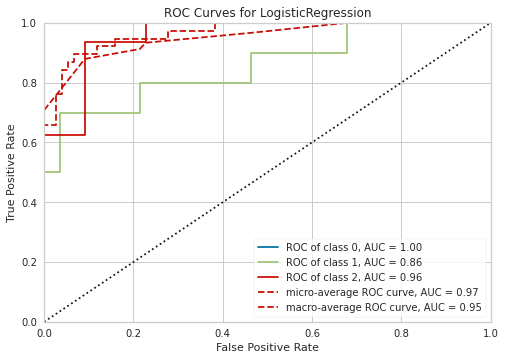

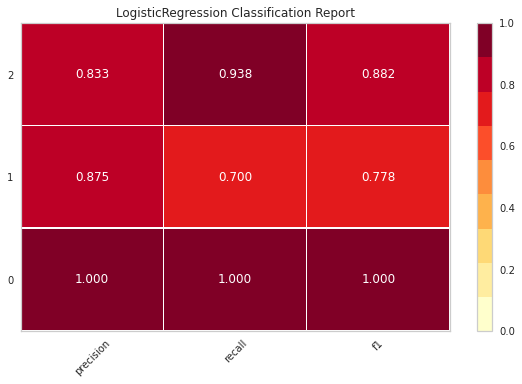

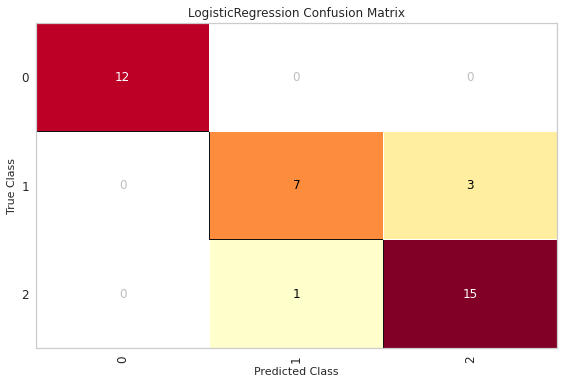

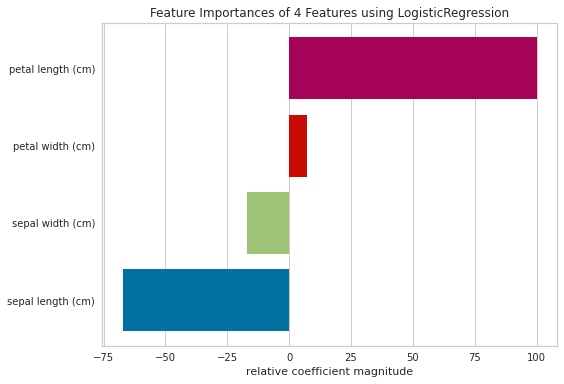

> 2020-10-26 07:17:37,792 [info] Log artifacts
> 2020-10-26 07:17:38,098 [info] Done!
> 2020-10-26 07:17:35,496 [info] Read Data
> 2020-10-26 07:17:35,594 [info] Prep Data
> 2020-10-26 07:17:35,887 [info] Split and Train
> 2020-10-26 07:17:36,020 [info] Evaluate
> 2020-10-26 07:17:37,792 [info] Log artifacts
> 2020-10-26 07:17:38,098 [info] Done!

> 2020-10-26 07:17:38,160 [warning] run ended with state 


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...6aa8b6db,0,Oct 26 07:17:35,completed,sklearn_linear_model_LogisticRegression,v3io_user=adminkind=daskowner=adminhost=jupyter-856469cd66-vd7fwclass=sklearn.linear_model.LogisticRegression,dataset,model_pkg_class=sklearn.linear_model.LogisticRegressionlabel_column=labelCLASS_solver=liblinear,micro=0.9664127423822715macro=0.951954816017316precision-0=1.0precision-1=0.875precision-2=0.8333333333333334recall-0=1.0recall-1=0.7recall-2=0.9375f1-0=1.0f1-1=0.7777777777777777f1-2=0.8823529411764706,ROCAUCClassificationReportConfusionMatrixFeatureImportancesmodelstandard_scalerlabel_encodertest_set


to track results use .show() or .logs() or in CLI: 
!mlrun get run e8558cafa5f44bb8987e96046aa8b6db --project default , !mlrun logs e8558cafa5f44bb8987e96046aa8b6db --project default
> 2020-10-26 07:17:38,176 [info] run executed, status=completed


In [36]:
outputs = []
for model in models:
    task_copy = task_params.copy()
    task_copy.update(
        {
            "params":{ "model_pkg_class" : model,
                       "label_column"    : "label"}
        }
    )
    
    # customize specific model parameters
    if "RandomForestClassifier" in model:
        task_copy["params"].update({"CLASS_max_depth" : 5})

    if "LogisticRegression" in model:
        task_copy["params"].update({"CLASS_solver" : "liblinear"})
    
    if "AdaBoostClassifier" in model:
        task_copy["params"].update({"CLASS_n_estimators"  : 200,
                                    "CLASS_learning_rate" : 0.01
                                   })
    
    name = model.replace('.', '_')
    output = dsf.run(mlrun.NewTask(**task_copy),
                             handler=train_model,
                             name=name,
                             inputs={"dataset"  : DATA_URL}, 
                             artifact_path=os.path.join(artifact_path, model))
    
    outputs.append({name: output.outputs})